#Introduction to Keras
The following notebook will introduce you to Keras, one of the most popular high-level machine learning Python pacakges. In this notebook we will examine how to create a neural network to predict the class of three iris species. Additionally, we will perform basic hyperparameter tuning.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import train_test_split
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings 
warnings.filterwarnings('ignore')

The first step is to load the iris dataset using the load_iris function

In [3]:
#load dataset
iris_data = load_iris()
#split into x and y sets
iris_data_x = iris_data.data
iris_data_y = iris_data.target

Next we will split our data into a training and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris_data_x, iris_data_y, test_size=0.3, random_state = 42)

Now we will scale our features, remembering to be cautious of data leakage.

In [5]:
#scale the features to be between 0 and 1
scaler = MinMaxScaler()
#fit scaler to the training set features
scaler.fit(X_train)
#scale the training and test set features using the transform method
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Text(0.5, 9.444444444444438, 'Value')

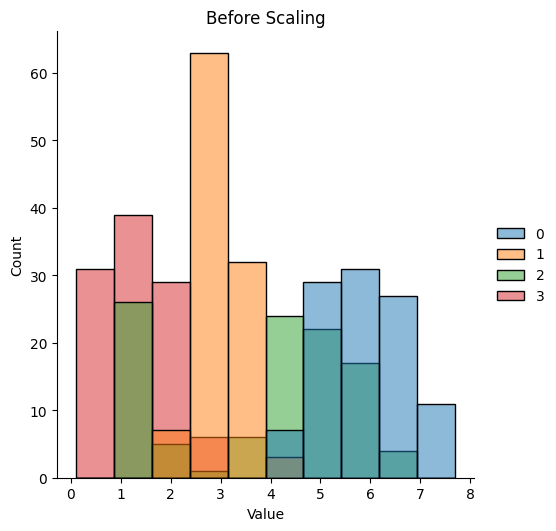

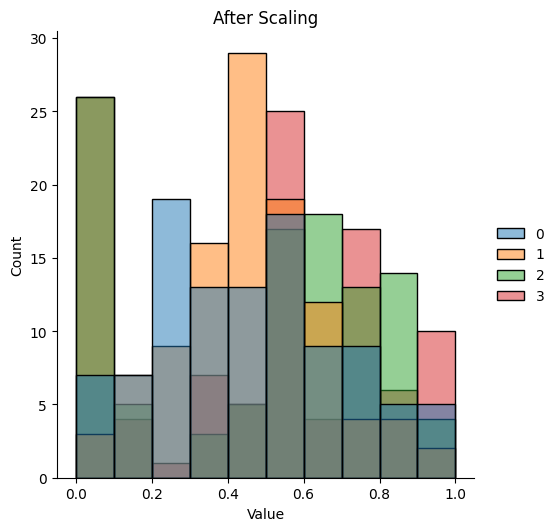

In [6]:
#check and see the scaled feature distribution
sns.displot(X_train)
plt.title("Before Scaling")
plt.xlabel("Value")
sns.displot(X_train_scaled)
plt.title("After Scaling")
plt.xlabel("Value")

Now that we have scaled our features, it's time to create our model.

In [7]:
#create a sequential model object
model = Sequential()
#add an input layer specifying 10 units and a sigmoid activation function
#note: input shape must be specified on the first layer and should be equal to the number of features
model.add(Dense(10, input_shape=(X_train_scaled.shape[1],), activation = 'sigmoid'))
#add a hidden layer with 5 units and a sigmoid activation function
model.add(Dense(5, activation='sigmoid'))
#add an output layer with 3 hidden units, one for each of the possible predictions with a sigmoid activation
model.add(Dense(3, activation='sigmoid'))

In [8]:
#compile the model specifying an optimizer and a loss function
model.compile(optimizer = 'SGD', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [9]:
#print a summary of the mode
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 123 (492.00 B)

 Non-trainable params: 0 (0.00 B)

None


Now that the model is ready, we will train it and evaluate its performance.

In [9]:
#fit the model on the data and specify the number of training iterations (epochs)
model.fit(X_train_scaled, y_train, epochs = 200, verbose=0)

In [10]:
#evaluate the model's performance on the test data
model.evaluate(X_test_scaled, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 1.0740 - sparse_categorical_accuracy: 0.2444


[1.07395339012146, 0.24444444477558136]

While Keras is a high-level library that uses the Tensorflow backend, it allows high levels of flexibility through its Functional API. The following will show how to implement our model using the Keras Functional API.

In [11]:
#build the same model using the Keras Functional API

#define the input
input = Input(shape=(iris_data_x.shape[1],))
#define the first hidden layer and the previously connected layer
hidden1 = Dense(10, activation = 'sigmoid')(input)
#define the second hidden layer and the previously connected layer
hidden2 = Dense(5, activation = 'sigmoid')(hidden1)
#define the ouput layer and the previously connected layer
output = Dense(3, activation = 'sigmoid')(hidden2)

#create the model object
model_api = Model(input,output)

In [12]:
#print the model summary
model_api.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 10)                50        
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


Now let's see how we would perform hyperparameter tuning using our model.

In [17]:
#to preform a gridsearch to determine the best hyperparameters for training we need to create a function that returns a new model
#the function should take as an argument the hyperparameters we are chosing to optimize
def create_model(optimizer):
  #define the input
  input = Input(shape=(iris_data_x.shape[1],))
  #define the first hidden layer and the previously connected layer
  hidden1 = Dense(10, activation = 'sigmoid')(input)
  #define the second hidden layer and the previously connected layer
  hidden2 = Dense(5, activation = 'sigmoid')(hidden1)
  #define the ouput layer and the previously connected layer
  output = Dense(3, activation = 'sigmoid')(hidden2)
  #create the model object
  model_api = Model(input,output)
  #switch metric to accuracy for sklearn integration
  #compile the model since we are switching to accuracy as a metric, we must switch to categorical crossentropy
  model_api.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model_api

In [18]:
#we will perform a gridsearch on 3 optimizers
param_grid = dict(optimizer=['rmsprop', 'SGD','adam'])
#to use a keras model with sklearn we need to call a wrapper function where the build function is our previously defined function
hp_model = KerasClassifier(build_fn=create_model, verbose=0)
#instantiate gridsearch object using 3 fold crossvaliadtion
grid=GridSearchCV(estimator = hp_model, param_grid = param_grid, refit=True, cv=3)
#fit the gridsearch object on the data
#since we are switching to accuracy as a metric, we must one-hot-encode our output variable
grid_result = grid.fit(X_train_scaled, pd.get_dummies(y_train), epochs=200, verbose=0)
#determine the best parameter
print(grid_result.best_params_)

{'optimizer': 'rmsprop'}


In [19]:
#evaluate the gridsearch on the test data
grid_result.score(X_test_scaled, pd.get_dummies(y_test))

0.7111111283302307